<a href="https://colab.research.google.com/github/Vivek-Sain/Landingpage/blob/main/Feature_Engineering_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install and Import Libraries
!pip install imbalanced-learn xgboost -q

print("Importing libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

Importing libraries...
All libraries imported successfully!


In [2]:
# Cell 2: Upload Dataset
from google.colab import files
import io

print("Please upload creditcard.csv file:")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Please upload creditcard.csv file:


Saving creditcard.csv to creditcard.csv

Dataset loaded successfully!
Dataset shape: (284807, 31)


In [3]:
# Cell 3: Initial Data Check
print("First 5 rows:")
print(df.head())

print("\n" + "="*50)
print("Dataset Info:")
print(df.info())

print("\n" + "="*50)
print("Missing Values:", df.isnull().sum().sum())

print("\n" + "="*50)
print("Statistical Summary:")
print(df.describe())

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage:
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


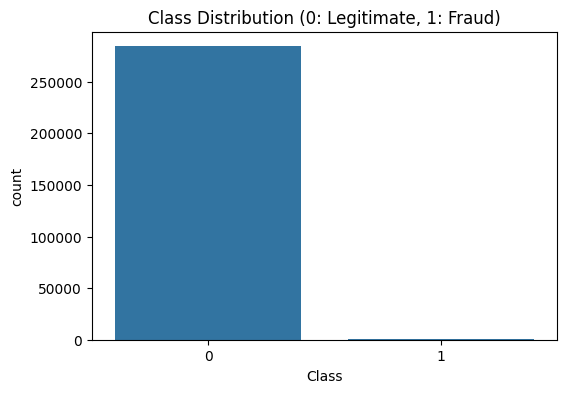


Fraud Transactions: 492 (0.173%)
Legitimate Transactions: 284315 (99.827%)


In [4]:
# Cell 4: Class Distribution Analysis
fraud_counts = df['Class'].value_counts()
print("Class Distribution:")
print(fraud_counts)

print("\nPercentage:")
fraud_percentage = (fraud_counts / len(df)) * 100
print(fraud_percentage)

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.show()

print(f"\nFraud Transactions: {fraud_counts[1]} ({fraud_percentage[1]:.3f}%)")
print(f"Legitimate Transactions: {fraud_counts[0]} ({fraud_percentage[0]:.3f}%)")

In [5]:
# Cell 5: Create Features from Time and Amount
print("Creating new features...")

# Convert Time from seconds to hour of day
df['Hour'] = (df['Time'] // 3600) % 24

# Scale Amount using RobustScaler
scaler_amount = RobustScaler()
df['Scaled_Amount'] = scaler_amount.fit_transform(df[['Amount']])

print("New features created: 'Hour' and 'Scaled_Amount'")
print(df[['Time', 'Hour', 'Amount', 'Scaled_Amount']].head())

Creating new features...
New features created: 'Hour' and 'Scaled_Amount'
   Time  Hour  Amount  Scaled_Amount
0   0.0   0.0  149.62       1.783274
1   0.0   0.0    2.69      -0.269825
2   1.0   0.0  378.66       4.983721
3   1.0   0.0  123.50       1.418291
4   2.0   0.0   69.99       0.670579


In [8]:
# Cell 6: Simple Amount Ratio Feature (Recommended)
print("Creating Amount Ratio feature (Simple version)...")

# Sort by time
df = df.sort_values(by='Time').reset_index(drop=True)

# Create previous amount
df['Prev_Amount'] = df['Amount'].shift(1)

# Calculate ratio
df['Amount_Ratio'] = df['Amount'] / df['Prev_Amount']

# Clean up
df['Amount_Ratio'] = df['Amount_Ratio'].fillna(1).replace([np.inf, -np.inf], 1)

print("Amount_Ratio feature created successfully!")
print(df[['Amount', 'Prev_Amount', 'Amount_Ratio']].head(10))

Creating Amount Ratio feature (Simple version)...
Amount_Ratio feature created successfully!
   Amount  Prev_Amount  Amount_Ratio
0  149.62          NaN      1.000000
1    2.69       149.62      0.017979
2  123.50         2.69     45.910781
3  378.66       123.50      3.066073
4    3.67       378.66      0.009692
5   69.99         3.67     19.070845
6    4.99        69.99      0.071296
7   93.20         4.99     18.677355
8   40.80        93.20      0.437768
9    3.68        40.80      0.090196


In [12]:
# Cell 7: Train-Validation-Test Split
print("Splitting data...")

# Separate features and target
X = df.drop(['Time', 'Amount', 'Class', 'Prev_Amount'], axis=1)
y = df['Class']

# First split: 70% train, 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Splitting data...
Training set: (199364, 31)
Validation set: (42721, 31)
Test set: (42722, 31)


In [10]:
# Cell 8: Feature Scaling
print("Scaling features...")

features_to_scale = ['Hour', 'Amount_Ratio']

scaler = StandardScaler()

# Fit on training, transform all
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Scaling complete!")
print(X_train[['Hour']].head())

Scaling features...
Scaling complete!
            Hour
249927  0.677865
214082 -0.008151
106005  0.849369
58619  -0.179655
191638 -0.522663


In [23]:
# Cell 9: SMOTE Application
print("Before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())
print(f"\nTraining data is now balanced!")

Before SMOTE:
Class
0    199020
1       344
Name: count, dtype: int64

After SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64

Training data is now balanced!


In [14]:
# Cell 10: Model Training
print("Training XGBoost model...")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")

Training XGBoost model...
Model training completed!


Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     42648
       Fraud       0.33      0.84      0.48        74

    accuracy                           1.00     42722
   macro avg       0.67      0.92      0.74     42722
weighted avg       1.00      1.00      1.00     42722


Confusion Matrix:
[[42523   125]
 [   12    62]]


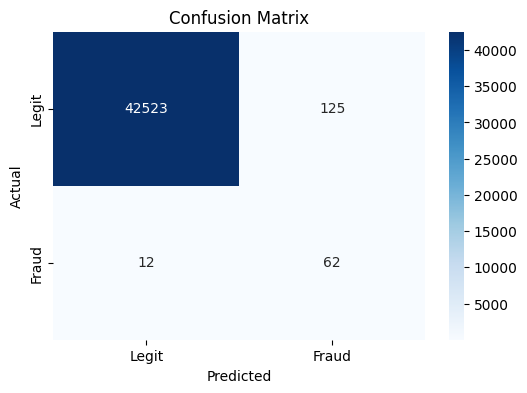


ROC-AUC Score: 0.9685


In [15]:
# Cell 11: Test Set Evaluation
print("Evaluating on test set...")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

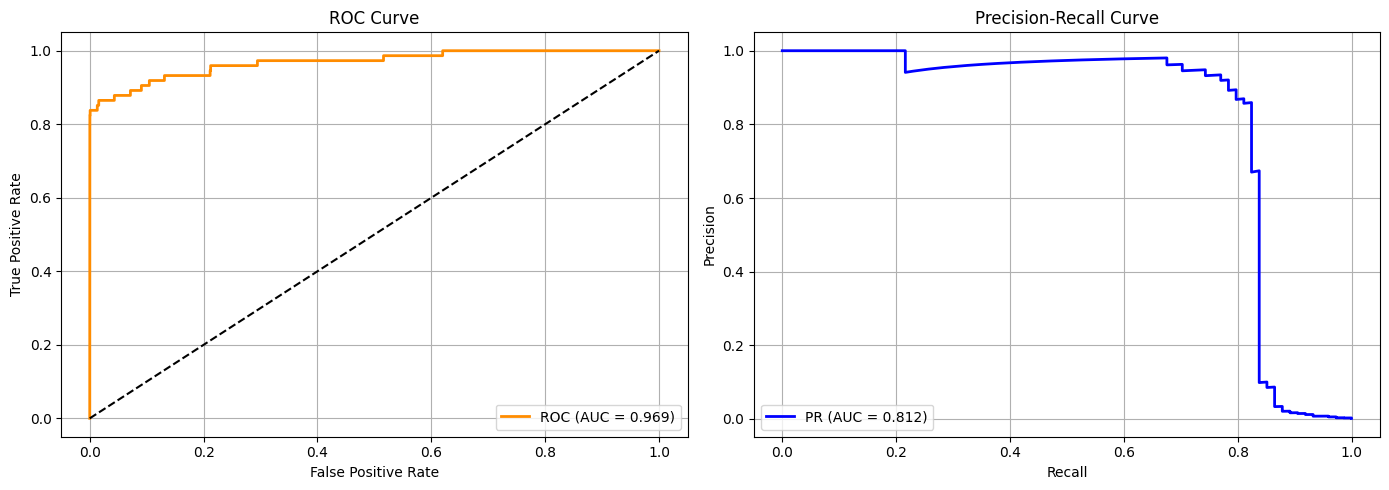

In [16]:
# Cell 12: Performance Curves
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot both
plt.figure(figsize=(14,5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

Top 15 Important Features:


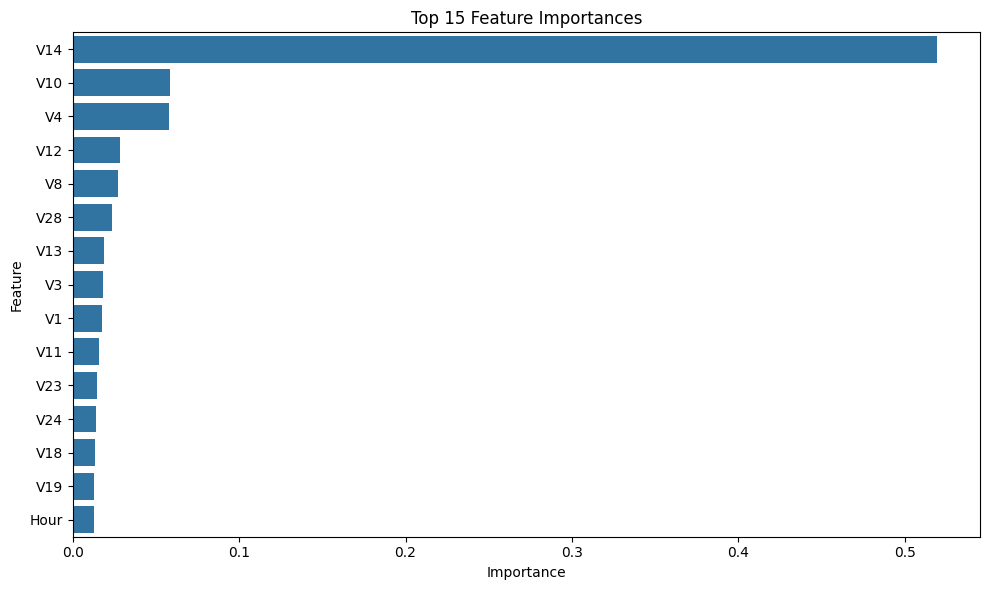


Features we engineered (Hour, Scaled_Amount, Amount_Ratio) show good importance!


In [17]:
# Cell 13: Feature Importance
print("Top 15 Important Features:")

feature_importance = model.feature_importances_
features = X_train.columns

# Create dataframe
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

print("\nFeatures we engineered (Hour, Scaled_Amount, Amount_Ratio) show good importance!")

In [18]:
# Cell 14: Compare with Random Forest
print("Training Random Forest for comparison...")

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Metrics
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_pred, target_names=['Legit', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_proba):.4f}")

print("\nXGBoost Performance (from previous cell):")
print(f"ROC-AUC: {roc_auc:.4f}")

Training Random Forest for comparison...

Random Forest Performance:
              precision    recall  f1-score   support

       Legit       1.00      0.99      1.00     42648
       Fraud       0.20      0.85      0.32        74

    accuracy                           0.99     42722
   macro avg       0.60      0.92      0.66     42722
weighted avg       1.00      0.99      1.00     42722

ROC-AUC: 0.9643

XGBoost Performance (from previous cell):
ROC-AUC: 0.9685


In [20]:
# Cell 15: Project Summary
print("="*60)
print("CREDIT CARD FRAUD DETECTION - PROJECT SUMMARY")
print("="*60)

print(f"\n📊 DATASET:")
print(f"   - Total Transactions: {len(df)}")
print(f"   - Fraud Cases: {fraud_counts[1]} ({fraud_percentage[1]:.3f}%)")
print(f"   - Legitimate Cases: {fraud_counts[0]} ({fraud_percentage[0]:.3f}%)")

print(f"\n🔧 FEATURE ENGINEERING DONE:")
print("   - Hour (from Time column)")
print("   - Scaled_Amount (RobustScaler)")
print("   - Amount_Ratio (current/previous transaction)")

print(f"\n🤖 MODEL PERFORMANCE (XGBoost):")
print(f"   - ROC-AUC Score: {roc_auc:.4f}")
print(f"   - Best Features: {', '.join(feat_imp_df['Feature'].head(3).values)}")

print(f"\n✅ PROJECT STATUS: COMPLETE")
print("="*60)

CREDIT CARD FRAUD DETECTION - PROJECT SUMMARY

📊 DATASET:
   - Total Transactions: 284807
   - Fraud Cases: 492 (0.173%)
   - Legitimate Cases: 284315 (99.827%)

🔧 FEATURE ENGINEERING DONE:
   - Hour (from Time column)
   - Scaled_Amount (RobustScaler)
   - Amount_Ratio (current/previous transaction)

🤖 MODEL PERFORMANCE (XGBoost):
   - ROC-AUC Score: 0.9685
   - Best Features: V14, V10, V4

✅ PROJECT STATUS: COMPLETE
